In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

#Zoo environment set-up
class ZooEnv:
    def __init__(self,
                 dims=(6, 6),
                rewards={'r_time': -2, 'r_cleaning': -7, 'r_animal': 40, 'r_exit_all': 30, 'r_exit_partial': -7, 'r_tunnel1': -7, 'r_tunnel2': 17},
                 start=(3, 0),
                 end=(4, 5),
                 positions={'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]},
                 tunnels={(0, 5): (2, 4), (2, 4): (0, 5)},
                 epsilon_decays={'epsilon_threshold': 0.5, 'epsilon_decay1': 0.99999, 'epsilon_decay2': 0.9999},
                 max_steps=100,
                 max_episodes=500,
                 random_seed=42):
        self._dims = dims
        self._rewards = rewards
        self._start = start
        self._end = end
        self._tunnels = tunnels
        self._epsilon_decays = epsilon_decays
        self._positions = positions
        self._max_steps = max_steps
        self._max_episodes = max_episodes
        self.current_state = start
        self.visited_animals = set()

        self._initialize_grid()
        self._initialize_R_matrix()
        self._initialize_Q_matrix()

        self.rng = np.random.default_rng(random_seed)

    def _initialize_grid(self):
        self._grid = np.zeros(self._dims)
        for position in self._positions:
            for pos in self._positions[position]:
                self._grid[pos[0], pos[1]] = self._rewards['r_' + position]
        self._grid[self._end[0], self._end[1]] = self._rewards['r_exit_all']

    def visualise_world(self):
        W = self._dims[1] * 2 + 1
        H = self._dims[0] * 2 + 1
        rows = [['   '] * W for _ in range(H)]
        for i in range(W):
            for j in range(H):
                if i % 2 == 1 and j % 2 == 1:
                    rows[j][i] = '.  '
        rows[0] = ['X  ' for _ in rows[0]]
        rows[H - 1] = ['X  ' for _ in rows[H - 1]]
        for i in range(1, H - 1):
            rows[i][0] = 'X  '
            rows[i][W - 1] = 'X  '

        for tunnel in self._tunnels:
            rows[tunnel[0] * 2 + 1][tunnel[1] * 2 + 1] = 'T  '
        for label, p in [('S  ', self._start), ('E  ', self._end)]:
            rows[p[0] * 2 + 1][p[1] * 2 + 1] = label

        symbol = {'animal': 'A  ', 'cleaning': 'C  '}
        for key in self._positions:
            for p in self._positions[key]:
                rows[p[0] * 2 + 1][p[1] * 2 + 1] = symbol[key]
        return self._create_viz_string(rows)

    def _create_viz_string(self, rows):
        s = '\n' + ''.join([''.join(r) + '\n' for r in rows])
        s += '\n'
        s += 'key:\n'
        s += 'S  = start location for agent\n'
        s += 'E  = end location for agent\n'
        s += '.  = empty cell\n'
        s += 'X  = boundary or wall between cells\n'
        s += 'T  = tunnel start or end. Agent can travel between two tunnel points in one time step\n'
        s += 'A  = animal: agent is rewarded for visiting\n'
        s += 'C  = cleaning area: agent is penalized for moving into\n'
        return s

    def _initialize_R_matrix(self):
        d1 = self._dims[0]
        d2 = self._dims[1]
        self._R = np.empty((d1 * d2, d1 * d2))
        self._R.fill(np.nan)

        self.__fillPossibleActions()
        self.__initializeTunnels()
        self.__initializeAnimals()
        self.__initializeCleaning()
        self.__initializeGoalPoint()

    def move_to(self, l, feature):
        cell = feature[0] * self._dims[1] + feature[1]
        if feature[0] > 0:
            l.append((cell - self._dims[1], cell))
        if feature[0] < self._dims[0] - 1:
            l.append((cell + self._dims[1], cell))
        if feature[1] > 0:
            l.append((cell - 1, cell))
        if feature[1] < self._dims[1] - 1:
            l.append((cell + 1, cell))
        return l

    def __fillPossibleActions(self):
        ones = []
        for i in range(self._dims[0]):
            for j in range(self._dims[1]):
                cell = i * self._dims[1] + j
                if j != self._dims[1] - 1:
                    ones.append((cell + 1, cell))
                if i != self._dims[0] - 1:
                    ones.append((cell + self._dims[1], cell))
                if i != 0:
                    ones.append((cell - self._dims[1], cell))
                if j != 0:
                    ones.append((cell - 1, cell))
                ones.append((cell, cell))
        ones = tuple(zip(*ones))
        self._R[ones] = self._rewards['r_time']

    def __initializeGoalPoint(self):
        end_cell = self._end[0] * self._dims[1] + self._end[1]
        ends = self.move_to([], self._end)
        ends.append([end_cell, end_cell])
        ends = tuple(zip(*ends))
        self._R[ends] = self._rewards['r_exit_all']

    def __initializeTunnels(self):
        tunnel_cells = []
        for start, end in self._tunnels.items():
            start_cell = start[0] * self._dims[1] + start[1]
            end_cell = end[0] * self._dims[1] + end[1]
            tunnel_cells.append((start_cell, end_cell))
            tunnel_cells.append((end_cell, start_cell))
        tunnel_cells = tuple(zip(*tunnel_cells))
        self._R[tunnel_cells] = self._rewards['r_tunnel1']

    def __initializeAnimals(self):
        animals = []
        for animal in self._positions['animal']:
            animals = self.move_to(animals, animal)
        animals = tuple(zip(*animals))
        self._R[animals] = self._rewards['r_animal']

    def __initializeCleaning(self):
        cleaning = []
        for clean in self._positions['cleaning']:
            p = clean[0] * self._dims[1] + self._dims[1]
            cleaning = self.move_to(cleaning, clean)
            cleaning.extend([(p, p)])
        cleaning = tuple(zip(*cleaning))
        self._R[cleaning] = self._rewards['r_cleaning']

    def display_matrix(self, matrix, start=None, end=None):
        pd.set_option("display.max_columns", None)
        print(pd.DataFrame(matrix).loc[start:end, start:end])

    def _initialize_Q_matrix(self):
        self._Q = np.zeros(self._R.shape)

    def step(self, action):
        x, y = self.current_state
        if action == 0:  #up
            x -= 1
        elif action == 1:  #down
            x += 1
        elif action == 2:  #left
            y -= 1
        elif action == 3:  #right
            y += 1

        #check boundaries
        if x < 0 or x >= self._dims[0] or y < 0 or y >= self._dims[1]:
            return self.current_state, self._rewards['r_time'], True, {}

        #tunnels
        if (x, y) in self._tunnels:
            x, y = self._tunnels[(x, y)]

        self.current_state = (x, y)
        reward = self._grid[x, y]

        #animals visited
        if (x, y) in self._positions['animal'] and (x, y) not in self.visited_animals:
            self.visited_animals.add((x, y))

        #episode termination
        done = self.current_state == self._end
        return self.current_state, reward, done, {}

    def reset(self):
        self.current_state = self._start
        self.visited_animals = set()
        return self.current_state

    def render(self):
        print(self.visualise_world())



In [136]:
#Basic DQN
class BasicDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicDQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.layers(x)
#replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)



In [132]:
#DQN agent
class DQNAgent:
    def __init__(self, env, input_dim, output_dim, buffer_capacity=10000, batch_size=64, gamma=0.99, alpha=0.001, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500):
        self.env = env
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = BasicDQN(input_dim, output_dim).to(self.device)
        self.target_net = BasicDQN(input_dim, output_dim).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=alpha)
        self.memory = ReplayBuffer(buffer_capacity)

        self.update_target_net()
        self.rewards = []  # List to store rewards
        self.animals_visited = []  # List to store number of animals visited

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def select_action(self, state):
        sample = random.random()
        self.steps_done += 1
        self.epsilon = self.epsilon_min + (1.0 - self.epsilon_min) * np.exp(-1. * self.steps_done / self.epsilon_decay)
        if sample > self.epsilon:
            with torch.no_grad():
                state = state.unsqueeze(0).to(self.device)
                return self.policy_net(state).max(1)[1].item()
        else:
            return random.randint(0, 3)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.add(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

        state_batch = torch.tensor(batch_state, dtype=torch.float32).to(self.device)
        action_batch = torch.tensor(batch_action).unsqueeze(1).to(self.device)
        reward_batch = torch.tensor(batch_reward, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_state_batch = torch.tensor(batch_next_state, dtype=torch.float32).to(self.device)
        done_batch = torch.tensor(batch_done, dtype=torch.float32).unsqueeze(1).to(self.device)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = self.target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
        expected_state_action_values = reward_batch + (self.gamma * next_state_values * (1 - done_batch))

        loss = F.mse_loss(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    #train the DQN agent
    def train(self, num_episodes):
        for episode in range(num_episodes):
            state = self.env.reset()
            state = self.convert_state(state)
            total_reward = 0
            for t in range(self.env._max_steps):
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.convert_state(next_state)
                self.store_transition(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                self.optimize_model()
                if done:
                    break
            self.rewards.append(total_reward)  #total reward of this episode
            self.animals_visited.append(len(self.env.visited_animals))  #number of animals visited
            self.update_target_net()
            print(f"Episode {episode} - Total reward: {total_reward}, Animals visited: {len(self.env.visited_animals)}")

    def convert_state(self, state):
        # Convert state to 1D tensor
        state_index = state[0] * self.env._dims[1] + state[1]
        state_tensor = torch.zeros(self.env._dims[0] * self.env._dims[1])
        state_tensor[state_index] = 1.0
        return state_tensor.to(self.device)

def plot_rewards(rewards):
    plt.figure(figsize=(12, 5))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.show()

def plot_moving_average(rewards, window=10):
    moving_avg = [np.mean(rewards[i-window:i]) for i in range(window, len(rewards))]
    plt.figure(figsize=(12, 5))
    plt.plot(range(window, len(rewards)), moving_avg)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average of Total Reward per Episode')
    plt.show()

def plot_q_values(agent):
    states = np.arange(agent.env._dims[0] * agent.env._dims[1])
    q_values = []

    for state in states:
        state_tensor = torch.zeros(agent.env._dims[0] * agent.env._dims[1])
        state_tensor[state] = 1.0
        state_tensor = state_tensor.unsqueeze(0).to(agent.device)
        q_value = agent.policy_net(state_tensor).cpu().detach().numpy()
        q_values.append(q_value)

    q_values = np.array(q_values)

    plt.figure(figsize=(12, 5))
    for action in range(agent.env._dims[1]):
        plt.plot(states, q_values[:, action], label=f'Action {action}')
    plt.xlabel('State')
    plt.ylabel('Q-value')
    plt.title('Q-values for Different Actions')
    plt.legend()
    plt.show()




Episode 0 - Total reward: 38.0, Animals visited: 1
Episode 1 - Total reward: 38.0, Animals visited: 1
Episode 2 - Total reward: 64.0, Animals visited: 1
Episode 3 - Total reward: -2.0, Animals visited: 0
Episode 4 - Total reward: -2.0, Animals visited: 0
Episode 5 - Total reward: 24.0, Animals visited: 1
Episode 6 - Total reward: -2, Animals visited: 0
Episode 7 - Total reward: 38.0, Animals visited: 1
Episode 8 - Total reward: 38.0, Animals visited: 1
Episode 9 - Total reward: -2.0, Animals visited: 0
Episode 10 - Total reward: 78.0, Animals visited: 1
Episode 11 - Total reward: 38.0, Animals visited: 1
Episode 12 - Total reward: -2.0, Animals visited: 0
Episode 13 - Total reward: -2.0, Animals visited: 0
Episode 14 - Total reward: -2, Animals visited: 0
Episode 15 - Total reward: 104.0, Animals visited: 1
Episode 16 - Total reward: 38.0, Animals visited: 1
Episode 17 - Total reward: -2.0, Animals visited: 0
Episode 18 - Total reward: -2.0, Animals visited: 0
Episode 19 - Total reward

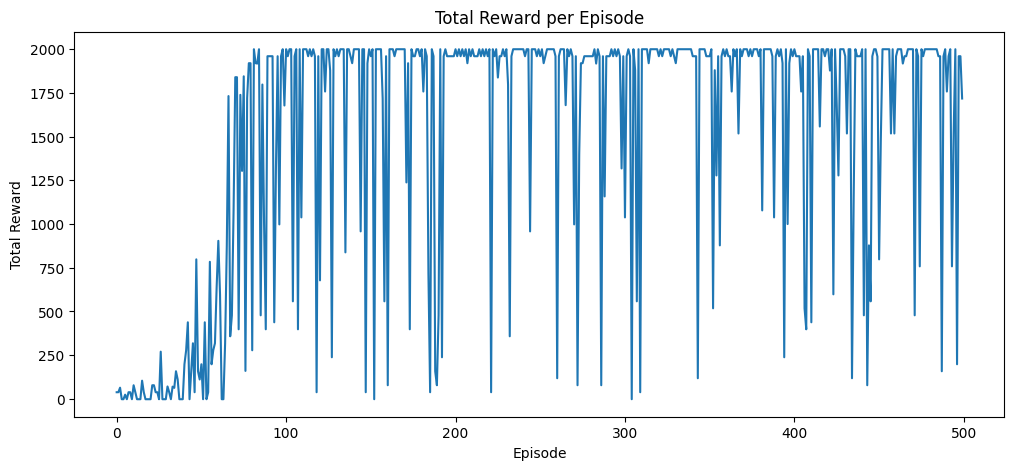

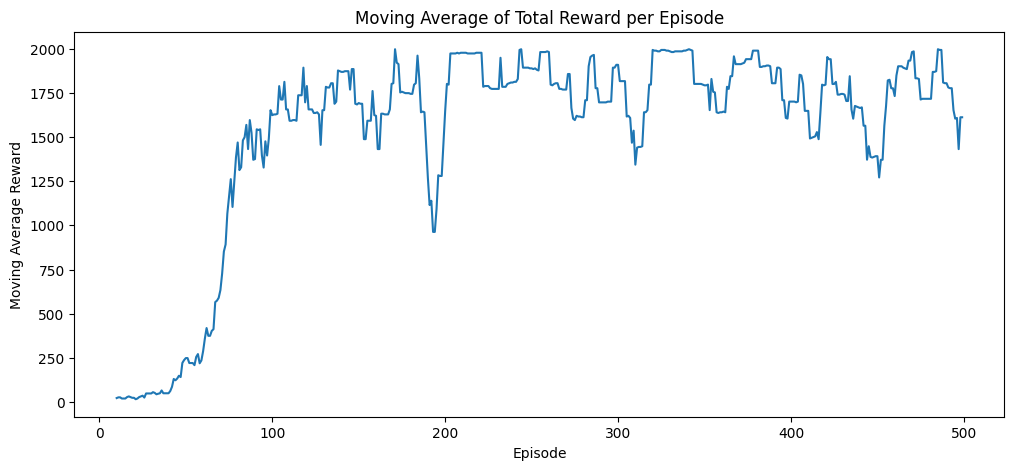

In [133]:
# Training the agent
env = ZooEnv()
input_dim = env._dims[0] * env._dims[1]  #6x6 grid
output_dim = 4  #actions =>up, down, left, right

agent = DQNAgent(env, input_dim, output_dim)

# Train the agent
agent.train(env._max_episodes)

# Visualize the results
plot_rewards(agent.rewards)
plot_moving_average(agent.rewards)


In [ ]:
#duelingDQN improvment
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
        )
        self.advantage = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        self.value = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value = self.value(x)
        return value + advantage - advantage.mean()

In [ ]:
#PER improvment
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done):
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        batch = list(zip(*samples))
        states = torch.tensor(batch[0], dtype=torch.float32)
        actions = torch.tensor(batch[1])
        rewards = torch.tensor(batch[2], dtype=torch.float32)
        next_states = torch.tensor(batch[3], dtype=torch.float32)
        dones = torch.tensor(batch[4], dtype=torch.float32)
        return states, actions, rewards, next_states, dones, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.buffer)


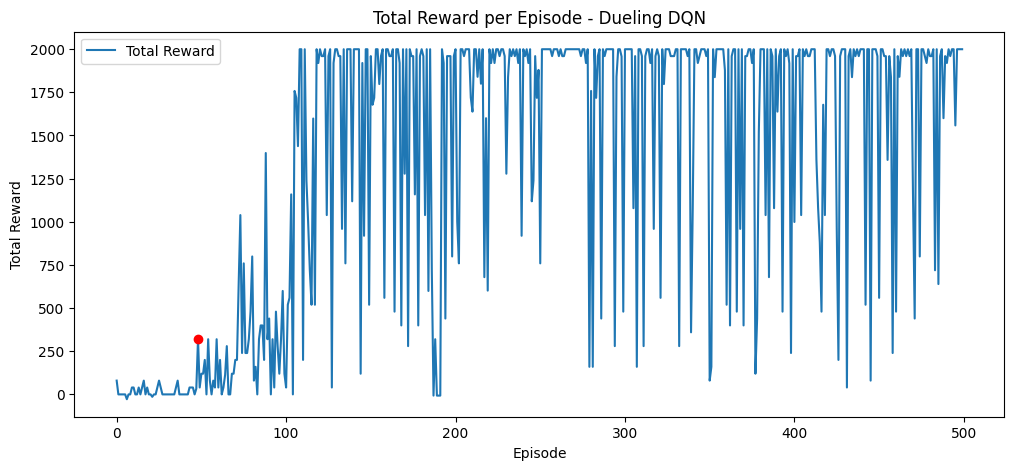

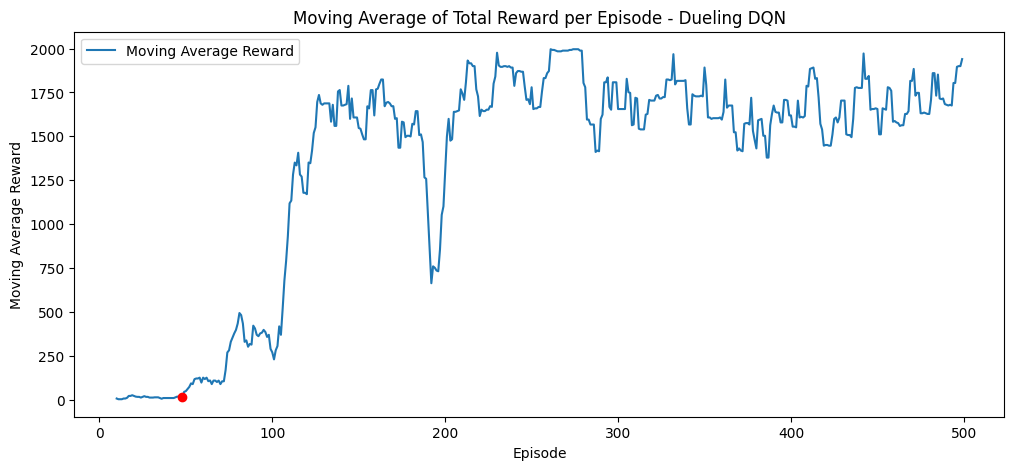

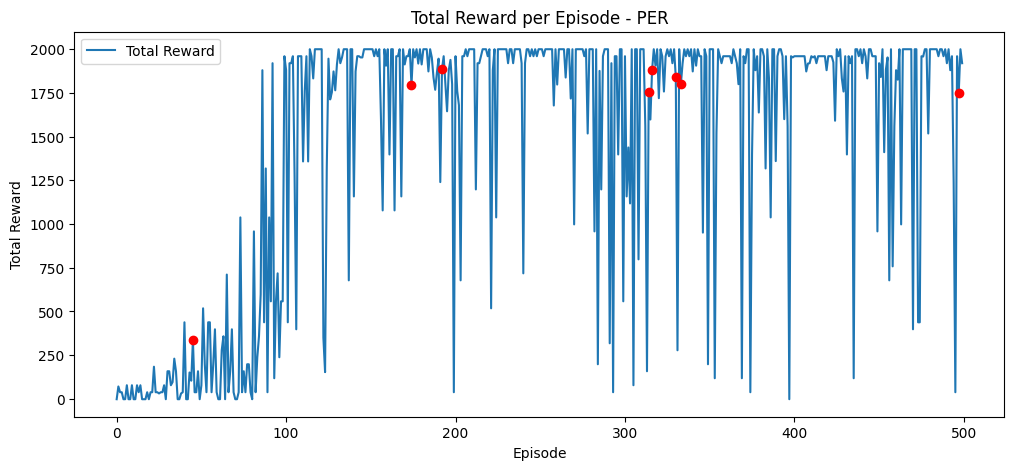

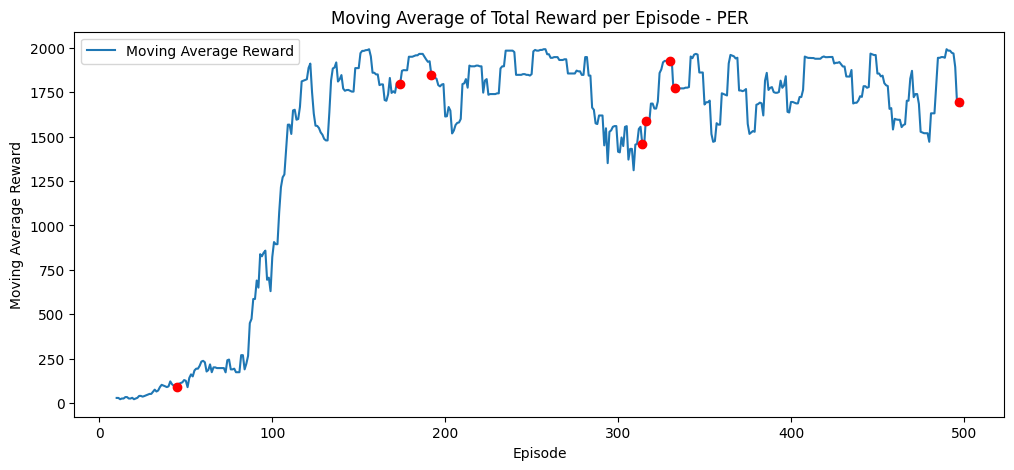

In [ ]:
#training agent for Dueling DQN
env = ZooEnv()
input_dim = env._dims[0] * env._dims[1]  #grid set up
output_dim = 4

agent_dueling = DQNAgent(env, input_dim, output_dim, use_dueling=True)
agent_dueling.train(env._max_episodes)

#results of Dueling DQN
def plot_rewards_dueling(rewards, animals_visited):
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode - Dueling DQN')
    for i, animals in enumerate(animals_visited):
        if animals > 2:
            plt.plot(i, rewards[i], 'ro')
    plt.legend()
    plt.show()

def plot_moving_average_dueling(rewards, animals_visited, window=10):
    moving_avg = [np.mean(rewards[i-window:i]) for i in range(window, len(rewards))]
    plt.figure(figsize=(12, 5))
    plt.plot(range(window, len(rewards)), moving_avg, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average of Total Reward per Episode - Dueling DQN')
    for i, animals in enumerate(animals_visited[window:], start=window):
        if animals > 2:
            plt.plot(i, moving_avg[i-window], 'ro')
    plt.legend()
    plt.show()

plot_rewards_dueling(agent_dueling.rewards, agent_dueling.animals_visited)
plot_moving_average_dueling(agent_dueling.rewards, agent_dueling.animals_visited)

# Training the agent for PER
agent_per = DQNAgent(env, input_dim, output_dim, use_per=True)
agent_per.train(env._max_episodes)

#results for PER
def plot_rewards_per(rewards, animals_visited):
    plt.figure(figsize=(12, 5))
    plt.plot(rewards, label='Total Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode - PER')
    for i, animals in enumerate(animals_visited):
        if animals > 2:
            plt.plot(i, rewards[i], 'ro')
    plt.legend()
    plt.show()

def plot_moving_average_per(rewards, animals_visited, window=10):
    moving_avg = [np.mean(rewards[i-window:i]) for i in range(window, len(rewards))]
    plt.figure(figsize=(12, 5))
    plt.plot(range(window, len(rewards)), moving_avg, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average of Total Reward per Episode - PER')
    for i, animals in enumerate(animals_visited[window:], start=window):
        if animals > 2:
            plt.plot(i, moving_avg[i-window], 'ro')
    plt.legend()
    plt.show()

plot_rewards_per(agent_per.rewards, agent_per.animals_visited)
plot_moving_average_per(agent_per.rewards, agent_per.animals_visited)
